In [2]:
import h5py
import os
import math
import numpy as np
import struct as st
from PIL import Image
import uuid
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Load dataset and transform them into input vectors
train_file = open('Data/MNIST dataset/train-images-idx3-ubyte', 'rb')
train_file_labels = open('Data/MNIST dataset/train-labels-idx1-ubyte', 'rb')
test_file = open('Data/MNIST dataset/t10k-images-idx3-ubyte', 'rb')
test_file_labels = open('Data/MNIST dataset/t10k-labels-idx1-ubyte', 'rb')

#Vectorizing training images
train_file.seek(0)
magic_training = st.unpack('>4B',train_file.read(4))
img_num = st.unpack('>I',train_file.read(4))[0]
rows = st.unpack('>I',train_file.read(4))[0]
columns = st.unpack('>I',train_file.read(4))[0]
x_train = np.zeros((img_num,rows,columns))
train_file.seek(16)
x_train = np.asarray(st.unpack('>' + 'B'*img_num*rows*columns, train_file.read(img_num*rows*columns))).reshape(img_num, rows, columns)

#Vectorizing training labels
train_file_labels.seek(0)
magic_training_label = st.unpack('>4B', train_file_labels.read(4))
num_labels = st.unpack('>I', train_file_labels.read(4))[0]
y_train = np.zeros((num_labels, 1))
y_train = np.asarray(st.unpack('>' + 'B'*num_labels, train_file_labels.read(num_labels)))

#Vectorizing test set images
test_file.seek(0)
magic_training = st.unpack('>4B',test_file.read(4))
img_num = st.unpack('>I',test_file.read(4))[0]
rows = st.unpack('>I',test_file.read(4))[0]
columns = st.unpack('>I',test_file.read(4))[0]
x_test = np.zeros((img_num,rows,columns))
test_file.seek(16)
x_test = np.asarray(st.unpack('>' + 'B'*img_num*rows*columns, test_file.read(img_num*rows*columns))).reshape(img_num, rows, columns)
x_test1 = x_test
#Vectorizing test set labels
test_file_labels .seek(0)
magic_training_label = st.unpack('>4B', test_file_labels .read(4))
num_labels = st.unpack('>I', test_file_labels .read(4))[0]
y_test = np.zeros((num_labels, 1))
y_test = np.asarray(st.unpack('>' + 'B'*num_labels, test_file_labels.read(num_labels)))
y_test1 = y_test
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
#Flatten arrays
x_train = np.reshape(x_train, (60000, 28*28), 'C')
x_test = np.reshape(x_test, (10000, 28*28), 'C')

#Scale data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
x_test_scaled = scaler.fit_transform(x_test.astype(np.float64))

#Create one hot vectors
y_train = np.identity(10)[y_train]
y_test = np.identity(10)[y_test]

#Create placeholder
x_train = x_train_scaled
print(x_train.shape)
x_test = x_test_scaled
print(x_test.shape)
y_train = y_train
print(y_train.shape)
y_test = y_test
print(y_test.shape)




(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [6]:
(n_x, m) = (x_train).shape     
print(n_x, m)

60000 784


Building Neural network

Step 1: Design NN architecture

In [7]:
def nn_ff(x):
    layer1 = tf.layers.dense(inputs = x, units = 40, activation = 'relu', name = 'layer1')
    layer2 = tf.layers.dense(inputs = layer1, units = 70, activation = 'relu', name = 'layer2')
    layer3 = tf.layers.dense(inputs = layer2, units = 25, activation = 'relu', name = 'layer3')
    y_out= tf.layers.dense(inputs = layer3, units = 10, activation = None, name = 'layer4')

    return y_out

In [8]:
def compute_cost(y_labeled, y_predicted):
    print("Inside compute_cost")
    print("y_predicted", y_predicted.shape)
    print("y_labeled", y_labeled.shape)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_predicted + 1e-8, labels = y_labeled))
    return cost
        


In [9]:
def mini_batches(x_train, y_train, mini_batch_size):
    
    m = x_train.shape[0]
    num_of_complete_mini_batches = math.floor(m/(mini_batch_size))
    mini_batches = []
    
    for k in range(0, num_of_complete_mini_batches):
        mini_batch_x = x_train[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_y= y_train[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
   
    if m % mini_batch_size != 0:
        mini_batch_x = x_train[num_of_complete_mini_batches * mini_batch_size : m, :]
        mini_batch_y = y_train[num_of_complete_mini_batches * mini_batch_size : m, :]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    
    return mini_batches
    
    

Build model

In [10]:
def model(x_train, y_train, x_test, y_test, learning_rate = 0.001, num_epochs = 100, minibatch_size = 512, print_cost = True):
    
    print("x_train", x_train.shape[1])
    print("y_train", y_train.shape[1])
    print("x_test", x_test.shape[1])
    print("y_test", y_test.shape[1])
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables                            # to keep consistent results
    (m, n_x) = x_train.shape                          # (n_x: input size, m : number of examples in the train set)
    print("m",m)
    n_y = y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost  
    
 

    
    #Create placeholders and a Saver
    X = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]), name = 'inputdata') 
    Y = tf.placeholder(tf.float32, shape=(None, y_train.shape[1]))
    
    
    y_predicted = nn_ff(X)
    print("y_predicted type", y_predicted)
    cost = compute_cost(Y, y_predicted)
    
    #Initialize parameters and define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    #Define accuracy
    acc = tf.equal(tf.argmax(y_predicted, axis=1), tf.argmax(Y, axis=1))
    acc = tf.reduce_mean(tf.cast(acc, dtype=tf.float32))
    
    with tf.Session() as sess:
        
        #Initialize variables
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        #Training loop
        for epoch in range(num_epochs):
            
            
            
            epoch_cost = 0.          # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = mini_batches(x_train, y_train, minibatch_size)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
            
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost = epoch_cost + minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print("Train performance: ", sess.run([acc], feed_dict={X: minibatch_X, Y: minibatch_Y}))
                print("Test performance: ", sess.run([acc], feed_dict={X: x_test, Y: y_test}))
            if print_cost == True:
                costs.append(epoch_cost)
                
            
             
                 
        #Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        #Extracting weights ?????
        #Testing accuracy ?????
        
        saver.save(sess, 'model/snn')
        
        
        sess.close()
    
    
    
        

    
    
            
        
        
        
    
    
    

x_train 784
y_train 10
x_test 784
y_test 10
m 60000
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
y_predicted type Tensor("layer4/BiasAdd:0", shape=(?, 10), dtype=float32)
Inside compute_cost
y_predicted (?, 10)
y_labeled (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.859870
Train performance:  [0.8645833]
Test performance:  [0.9009]
Cost after epoch 10: 0.096165
Train performance:  [0.9895833]
Test performance:  [0.966]
Cost after epoch 20: 0.055275
Train performance:  [1.0]
Test performance:  [0.9692]
Cost after epoch 30: 0.035063
Train performance:  [1.0]
Test performance:  [0.9669]
Cost after epoch 40: 0.025763
Train performance:  [1.0]
Test performance:  [0.9691]
Cost after epoch 5

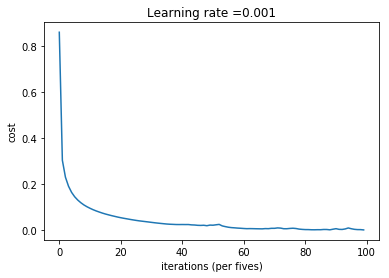

In [11]:
model(x_train, y_train, x_test, y_test, num_epochs = 100)

In [12]:
ops.reset_default_graph() 

Y = tf.placeholder(tf.float32, shape=(None, y_test.shape[1]))
with tf.Session() as sess:
    imported_graph = tf.train.import_meta_graph('model/snn.meta')
    imported_graph.restore(sess, tf.train.latest_checkpoint('model/'))
    
    graph = tf.get_default_graph()
    
    inputs = graph.get_tensor_by_name('inputdata:0')
    output = graph.get_tensor_by_name('layer4/BiasAdd:0')
    y_predicted = tf.nn.softmax(output)
    acc = tf.equal(tf.argmax(y_predicted, axis=1), tf.argmax(Y, axis=1))
    acc = tf.reduce_mean(tf.cast(acc, dtype=tf.float32))
    
    
    
    accuracy = sess.run(acc, feed_dict = {inputs : x_test, Y : y_test})
    print(accuracy)

    
    


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/snn
0.9688


INFO:tensorflow:Restoring parameters from model/snn
Prediction : [7]
Label : 7


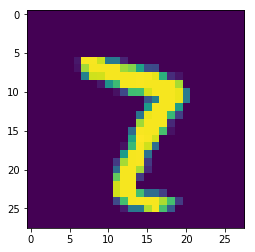

In [28]:
ops.reset_default_graph() 
rn = np.random.randint(0,9999)
with tf.Session() as sess:
    imported_graph = tf.train.import_meta_graph('model/snn.meta')
    imported_graph.restore(sess, tf.train.latest_checkpoint('model/'))
    
    graph = tf.get_default_graph()
    
    inputs = graph.get_tensor_by_name('inputdata:0')
    output = graph.get_tensor_by_name('layer4/BiasAdd:0')
    y_predicted = tf.argmax(tf.nn.softmax(output), axis = 1)
    
    
    one_prediction = sess.run(y_predicted, feed_dict = {inputs : np.expand_dims(x_test[rn], axis = 0)})
    print("Prediction :", one_prediction)
    print("Label :", np.argmax(y_test[rn]))
    
    
plt.imshow(x_test1[rn])
plt.show()